(activity14_solution)=

# Activity 14 Solution: Panel data

**2025-04-15**

---

In [1]:
import linearmodels as lm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Part 1

![](../images/lec19_panel.png)

With panel data, instead of having a single row per unit in our dataframes, we have potentially multiple datapoints per unit across time. Given that:

- December: $t=1$
- March: $t=2$
- June: $t=3$

We have 3 datapoints for each town. The "Post-treatment period?" column is a binary variable that is 1 if the datapoint is in the post-treatment period and 0 otherwise. 

Finish populating the markdown table below with the correct values:

| Unit         | Time | Outcome | Post-treatment period? |
|--------------|------|---------|------------------------|
| South Hadley | 1    | 100     | 0         |
| South Hadley | 2    | 90      | 0         |
| South Hadley | 3    | 70      | 1         |
| Hadley       | 1    | 80      | 0         |
| Hadley       | 2    | 70      | 0         |
| Hadley       | 3    | 60      | 1         |


We can use pandas [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html) to represent the multiple indices needed for panel data. The [pd.set_index()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html) can take a list of columns to use as the new index.

In [2]:
traffic_df = pd.DataFrame(
    {
        'town': ['South Hadley', 'South Hadley', 'South Hadley', 'Hadley', 'Hadley', 'Hadley'],
        'time': [1, 2, 3, 1, 2, 3],
        'outcome': [100, 90, 70, 80, 70, 60],
        "post_treatment": [0, 0, 1, 0, 0, 1]
    }
)

# Set the index to be the['town', 'time'] columns
traffic_df = traffic_df.set_index(["town", "time"])

display(traffic_df)

# note that time and town are no longer columns
display(traffic_df.columns)

,town,time,outcome,post_treatment
0,South Hadley,1,100,0
1,South Hadley,2,90,0
2,South Hadley,3,70,1
3,Hadley,1,80,0
4,Hadley,2,70,0
5,Hadley,3,60,1


Index(['town', 'time', 'outcome', 'post_treatment'], dtype='object')

The multi-index is now, where the first level (`level=0`) is the town and the second level (`level=1`) is the time.

With a multi-index, the `.loc` method can take a tuple that specifies an index to retrieve:

In [3]:
# selects all the South Hadley datapoints
display(traffic_df.loc["South Hadley"])


KeyError: 'South Hadley'

In [73]:
# selects the row for South Hadley at time 1
display(traffic_df.loc[("South Hadley", 1)])

# equivalently, we can chain the `.loc` method to filter different levels of the multi-index
display(traffic_df.loc["South Hadley"].loc[1])

outcome           100
post_treatment      0
Name: (South Hadley, 1), dtype: int64

outcome           100
post_treatment      0
Name: 1, dtype: int64

To select rows based on the second level of the multi-index, we can use [pd.xs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html), which takes a cross-section of the DataFrame:

In [75]:
# Select all rows where the second level of the multi-index (time) equals 1
traffic_df.xs(1, level=1)

,outcome,post_treatment
town,,
South Hadley,100,0
Hadley,80,0


Write a line of code to select the Hadley datapoint at time 3, and submit your answer to pollEverywhere:

- [pollev.com/tliu](https://pollev.com/tliu)

# Part 2

Run the cell below to load the organ donation data. The dataframe has the following columns:
- State: the state name
- Quarter: the quarter of data
- Quarter_Num: the quarter number
- Rate: the organ donation registration rate

In [124]:
organ_df = pd.read_csv("~/COMSC-341CD/data/organ_donations.csv")

Since the data is quarterly and begins in 2010 Q4, the first post-treatment period (after July 2011) is 2011 Q3, which corresponds to Quarter_Num = 4. Create the following columns to prepare the data for a difference-in-differences analysis:


- `is_california`: a binary variable indicating whether the state is California
- `post_treatment`: a binary variable indicating whether the quarter is after 2011 Q3 (Quarter_Num >= 4)
- `is_treated`: a binary variable indicating whether the state is California **AND** the quarter is after 2011 Q3

In [125]:
# TODO: Create the columns
organ_df['is_california'] = None
organ_df['post_treatment'] = None
organ_df['is_treated'] = None

### BEGIN SOLUTION
organ_df['is_california'] = organ_df['State'] == 'California'
organ_df['post_treatment'] = organ_df['Quarter_Num'] >= 4
organ_df['is_treated'] = organ_df['is_california'] & organ_df['post_treatment']
### END SOLUTION

Like we did in part 1, set the index to be the `['State', 'Quarter_Num']` columns.

In [126]:
organ_df = organ_df.set_index(['State', 'Quarter_Num'])

Finally, let's visually evaluate the parallel trends assumption by plotting the rate against the quarter number in the pre-treatment period.

<Axes: xlabel='Quarter_Num', ylabel='Rate'>

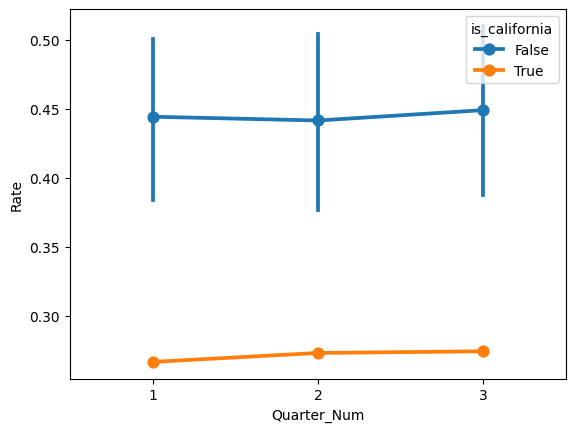

In [127]:
# Select the dataframe for the pre-treatment period
organ_df_pre = organ_df[organ_df['post_treatment']==False]

# Plot an sns.pointplot using organ_df_pre of 'Rate' against 'Quarter_Num', with 'is_california' as the hue
sns.pointplot(x='Quarter_Num', y='Rate', data=organ_df_pre, hue='is_california')

Does there appear to be any clear violations of the parallel trends assumption?

- [pollev.com/tliu](https://pollev.com/tliu)

# Part 3

We just discussed the following formula for using regression to compute a difference-in-differences estimate:

$$
Y = \beta_0 + \beta_1 (\text{treated group}) + \beta_2 (\text{after treatment}) + \beta_3 (\text{treated group} \times \text{after treatment}) + \epsilon
$$

Write the formula in terms of the variables in the `organ_df` dataframe we created in part 2. The outcome of interest is `Rate`, while the treated group is California.

In [129]:
formula = 'Rate ~ 1 + is_california + post_treatment + is_treated'
did_model = smf.ols(formula, data=organ_df)
did_results = did_model.fit()
print(did_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.015
Date:                Wed, 16 Apr 2025   Prob (F-statistic):             0.0317
Time:                        22:35:26   Log-Likelihood:                 78.895
No. Observations:                 162   AIC:                            -149.8
Df Residuals:                     158   BIC:                            -137.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

What is your ATT estimate of the effect of active choice vs opt-in on California organ donation rates?

- [pollev.com/tliu](https://pollev.com/tliu)

# Acknowledgements

This activity is derived from Nick Huntington-Klein's analysis of Kessler and Roth (2014) in Chapter 18 of [The Effect](https://theeffectbook.net/).